In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 


In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data")
os.listdir(path)

['.DS_Store',
 'Clean Books.ipynb',
 'cleaned',
 'imputated books',
 'imputated users',
 'merge book ratings',
 'raw',
 'READ MORE.txt',
 'README.txt']

In [3]:
books = pd.read_csv(path + "/cleaned/BX-Books.csv")
ratings = pd.read_csv(path + "/cleaned/BX-Ratings.csv")
users = pd.read_csv(path + "/cleaned/BX-Users.csv")

merged_bookratings = pd.merge(ratings, books, on='ISBN', how='inner')
data = pd.merge(merged_bookratings, users, on='User-ID', how='inner')

data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Book-Publisher', 'Book-Author-Processed',
       'Unnamed: 0', 'User-City', 'User-State', 'User-Country', 'User-Age',
       'Age-Group'],
      dtype='object')

In [4]:
from sklearn.cluster import KMeans

data = data[["Book-Title","User-ID"]]

book_count = data["Book-Title"].nunique()
user_count = data["User-ID"].nunique()
print("Number of book titles: "+ str(book_count))
print("Number of users: "+ str(user_count))
print("User to Book Ratio: " + str(user_count/book_count))

Number of book titles: 16109
Number of users: 45615
User to Book Ratio: 2.831646905456577


In [5]:
top_books = data.groupby("Book-Title")["Book-Title"].value_counts()
top_books = top_books.sort_values(ascending=False).head(100)
top_book_index = list(top_books.index)

top_books.head(60)

Book-Title
The Lovely Bones: A Novel                                                    643
Wild Animus                                                                  522
The Da Vinci Code                                                            461
The Secret Life of Bees                                                      383
The Nanny Diaries: A Novel                                                   363
Bridget Jones's Diary                                                        354
The Red Tent (Bestselling Backlist)                                          352
A Painted House                                                              338
Harry Potter and the Chamber of Secrets (Book 2)                             309
Life of Pi                                                                   305
Divine Secrets of the Ya-Ya Sisterhood: A Novel                              303
Angels & Demons                                                              294
Harry Potter and 

In [216]:
genres = []
dimensions = 3

for i in range(dimensions):
    for book in top_books.loc[top_books < 250].index:
        bk = data.loc[data["Book-Title"] == book]["User-ID"]
        unique = 1
        for genre in genres: 
            gn = data.loc[data["Book-Title"] == genre]["User-ID"]
            overlaps = bk.isin(gn)
            overlaps = overlaps.sum()
            if ((overlaps > 5)): 
                unique = 0
                break
        if unique:
            break
    if not unique:
            break
    print(top_books[book])
    genres.append(book)

genres


244
244
228


['The Catcher in the Rye', 'Timeline', 'Good in Bed']

In [217]:
samples = 500
supertop_books = top_books.sort_values(ascending=False).head(samples)

supertop_books.head(50)


Book-Title
The Lovely Bones: A Novel                                                    643
Wild Animus                                                                  522
The Da Vinci Code                                                            461
The Secret Life of Bees                                                      383
The Nanny Diaries: A Novel                                                   363
Bridget Jones's Diary                                                        354
The Red Tent (Bestselling Backlist)                                          352
A Painted House                                                              338
Harry Potter and the Chamber of Secrets (Book 2)                             309
Life of Pi                                                                   305
Divine Secrets of the Ya-Ya Sisterhood: A Novel                              303
Angels & Demons                                                              294
Harry Potter and 

In [218]:
top_data = data.loc[data["Book-Title"].isin(supertop_books.index)]

top_data

,Book-Title,User-ID
0,A Painted House,276744
4,Harry Potter and the Order of the Phoenix (Boo...,276788
6,Bridget Jones's Diary,276796
32,Ender's Game (Ender Wiggins Saga (Paperback)),276887
33,The King of Torts,276896
...,...,...
191660,The Da Vinci Code,276680
191685,Angels & Demons,276680
191694,The Poisonwood Bible: A Novel,276681
191695,Fast Food Nation: The Dark Side of the All-Ame...,276681


In [291]:

title_vectors = pd.DataFrame({"Book-Title":supertop_books.index})

def match(title, genre, weight):
    title = top_data.loc[data["Book-Title"] == title]["User-ID"]
    overlaps = title.isin(genre)
    overlaps = overlaps.sum()
    similarity = (overlaps/len(title))**0.2
    if similarity == 1:
        similarity = 0.5
    return similarity

for genre in genres:
    user_genre = top_data.loc[data["Book-Title"] == genre]["User-ID"]
    weight = 1/supertop_books[genre]
    title_vectors[genre] = title_vectors["Book-Title"].apply(match, args=(user_genre,weight))
    

title_vectors#.loc[title_vectors["Interview with the Vampire"] != 0]


# for each book title, create a new column for each user ID'''

,Book-Title,The Catcher in the Rye,Timeline,Good in Bed
0,The Lovely Bones: A Novel,0.504431,0.415887,0.534305
1,Wild Animus,0.394693,0.409351,0.377466
2,The Da Vinci Code,0.516832,0.522774,0.504055
3,The Secret Life of Bees,0.508334,0.482348,0.604829
4,The Nanny Diaries: A Novel,0.535603,0.440199,0.560047
...,...,...,...,...
95,We Were the Mulvaneys,0.539729,0.469862,0.556628
96,1984,0.664715,0.571694,0.520403
97,Icy Sparks,0.520403,0.433263,0.556628
98,Violets Are Blue,0.539729,0.539729,0.571694


In [292]:
title_vectors = title_vectors.set_index("Book-Title")


In [293]:
title_sums = title_vectors.sum(axis = 1)
title_sums.loc[(title_sums > 0)]

Book-Title
The Lovely Bones: A Novel     1.454624
Wild Animus                   1.181511
The Da Vinci Code             1.543662
The Secret Life of Bees       1.595510
The Nanny Diaries: A Novel    1.535849
                                ...   
We Were the Mulvaneys         1.566219
1984                          1.756812
Icy Sparks                    1.510294
Violets Are Blue              1.651153
Outlander                     1.430832
Length: 100, dtype: float64

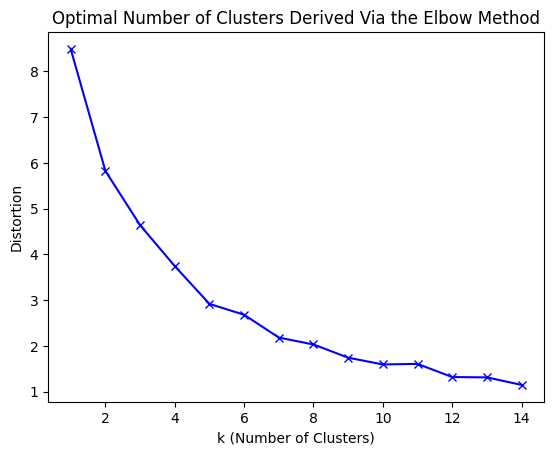

In [368]:
from sklearn.preprocessing import MinMaxScaler
normalized_data = MinMaxScaler().fit_transform(title_vectors)

distortions = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_data)
    distortions.append(kmeans.inertia_) # Question: What does kmeans.inertia_ return? 
    
plt.plot(k_range, distortions, 'bx-')

plt.title('Optimal Number of Clusters Derived Via the Elbow Method')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Distortion')

plt.show()

In [300]:
from scipy.spatial.distance import pdist, squareform

def VAT(R):
    """

    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

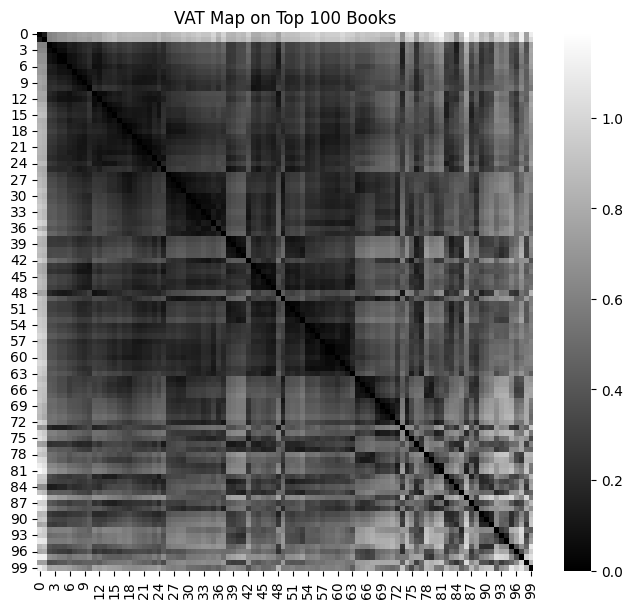

In [369]:
# Plot VAT

RV, _, I = VAT(normalized_data) # I are the reordered indices

plt.figure(figsize=(8, 7))
sns.heatmap(RV, cmap='gray')
title = "VAT on "
for genre in genres:
    title += "- "+genre+" "
plt.title("VAT Map on Top 100 Books")

plt.show()

In [302]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=7)
clusters.fit(title_vectors)

KMeans(n_clusters=7)

In [304]:
def plot_kmeans(df, clusters):
    """
    generate a 3d plot given sklearn's kmeans implementation 
    """
    colormap = {0: 'red', 1: 'green', 2: 'blue'}
    
    fig = plt.figure(figsize=(7, 10))
    ax = plt.axes(projection="3d")
    ax.scatter(df[genres[0]], 
               df[genres[1]], 
               df[genres[2]],
               c=[colormap.get(x) for x in clusters.labels_])
    
    ax.set_ylabel(genres[0])
    ax.set_xlabel(genres[1])
    ax.set_zlabel(genres[2])
    ax.set_title(f"k = {len(set(clusters.labels_))}")
    
    plt.show()

In [344]:
lil_title_vec = title_vectors.loc[title_vectors.index != "Bel Canto: A Novel"]
lil_title_vec = lil_title_vec.loc[lil_title_vec.index != "A Heartbreaking Work of Staggering Genius"]

lil_title_vec

,The Catcher in the Rye,Timeline,Good in Bed
Book-Title,,,
The Lovely Bones: A Novel,0.504431,0.415887,0.534305
Wild Animus,0.394693,0.409351,0.377466
The Da Vinci Code,0.516832,0.522774,0.504055
The Secret Life of Bees,0.508334,0.482348,0.604829
The Nanny Diaries: A Novel,0.535603,0.440199,0.560047
...,...,...,...
We Were the Mulvaneys,0.539729,0.469862,0.556628
1984,0.664715,0.571694,0.520403
Icy Sparks,0.520403,0.433263,0.556628


In [372]:
from scipy.spatial.distance import pdist, squareform

distance_matrix = pd.DataFrame(squareform(pdist(title_vectors))).astype(int)

def find_distance(row1, row2):
    row1 = title_vectors.iloc[row1]
    row2 = title_vectors.iloc[row2]

    x = (row1[genres[0]] - row2[genres[0]]) ** 2
    y = (row1[genres[1]] - row2[genres[1]]) ** 2
    z = (row1[genres[2]] - row2[genres[2]]) ** 2
    distance = (x + z + y) ** 0.5
    return distance


size = 100
for i in range(size):
    for ii in range(size):
        distance_matrix.iat[i, ii] = find_distance(i, ii)

#'''
distance_matrix

C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\1808924856.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19152950518831735' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  distance_matrix.iat[i, ii] = find_distance(i, ii)
C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\1808924856.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.11177514464896851' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  distance_matrix.iat[i, ii] = find_distance(i, ii)
C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\1808924856.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09698352197855116' has dtype incompatible with int32, please explicitly cast to a compa

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.191530,0.111775,0.096984,0.047174,0.046349,0.054914,0.134677,0.113092,0.054020,...,0.194293,0.138788,0.084146,0.061778,0.122487,0.068246,0.223964,0.032486,0.134092,0.114337
1,0.191530,0.000000,0.209302,0.264455,0.232686,0.227395,0.211176,0.200249,0.178416,0.182800,...,0.249608,0.320654,0.233340,0.252083,0.174819,0.238319,0.345974,0.220168,0.275242,0.155293
2,0.111775,0.209302,0.000000,0.108912,0.101519,0.149846,0.063958,0.048427,0.115342,0.085233,...,0.164599,0.166677,0.057452,0.122557,0.041357,0.078026,0.156620,0.103870,0.073395,0.086580
3,0.096984,0.264455,0.108912,0.000000,0.067272,0.107044,0.067783,0.122952,0.179768,0.120898,...,0.153088,0.063415,0.052821,0.062276,0.141705,0.058863,0.198911,0.069845,0.073323,0.130812
4,0.047174,0.232686,0.101519,0.067272,0.000000,0.056311,0.040390,0.132987,0.124129,0.065851,...,0.197588,0.103080,0.058665,0.025032,0.126998,0.030143,0.188501,0.017054,0.100294,0.132383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.068246,0.238319,0.078026,0.058863,0.030143,0.086370,0.028839,0.112303,0.124075,0.069770,...,0.186448,0.103264,0.033652,0.046525,0.109869,0.000000,0.165238,0.041388,0.071474,0.124080
96,0.223964,0.345974,0.156620,0.198911,0.188501,0.237430,0.180781,0.194521,0.188444,0.189133,...,0.297221,0.217163,0.167863,0.198866,0.184114,0.165238,0.000000,0.203227,0.138831,0.243124
97,0.032486,0.220168,0.103870,0.069845,0.017054,0.048663,0.040166,0.130843,0.124815,0.063708,...,0.190081,0.109380,0.062962,0.032242,0.125241,0.041388,0.203227,0.000000,0.109250,0.122931
98,0.134092,0.275242,0.073395,0.073323,0.100294,0.155622,0.081079,0.095088,0.168741,0.126888,...,0.166115,0.114693,0.051124,0.108440,0.113994,0.071474,0.138831,0.109250,0.000000,0.135138


C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\103708921.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hc = linkage(distance_matrix, 'complete')


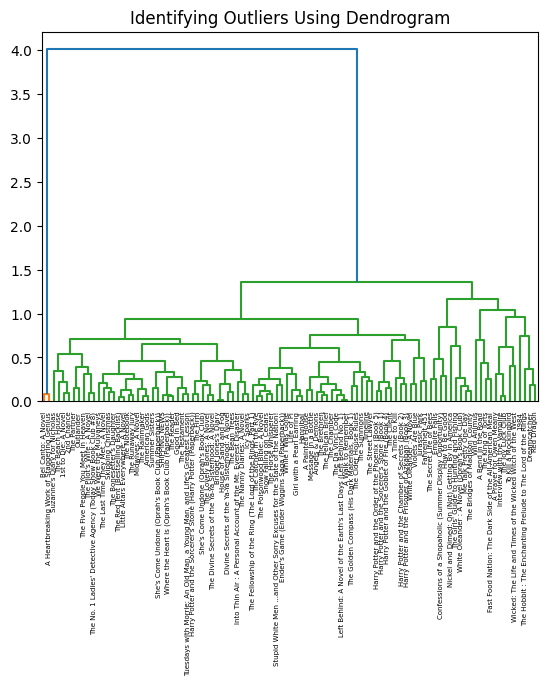

In [373]:
from scipy.cluster.hierarchy import dendrogram, linkage
D = pdist(distance_matrix)
hc = linkage(distance_matrix, 'complete')
dendrogram(hc, labels=title_vectors.index)
plt.title('Identifying Outliers Using Dendrogram')
plt.show()

C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\2309982676.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19152950518831735' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dist_matrix.iat[i, ii] = find_dist(i, ii)
C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\2309982676.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.11177514464896851' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dist_matrix.iat[i, ii] = find_dist(i, ii)
C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\2309982676.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09698352197855116' has dtype incompatible with int32, please explicitly cast to a compatible dtype firs

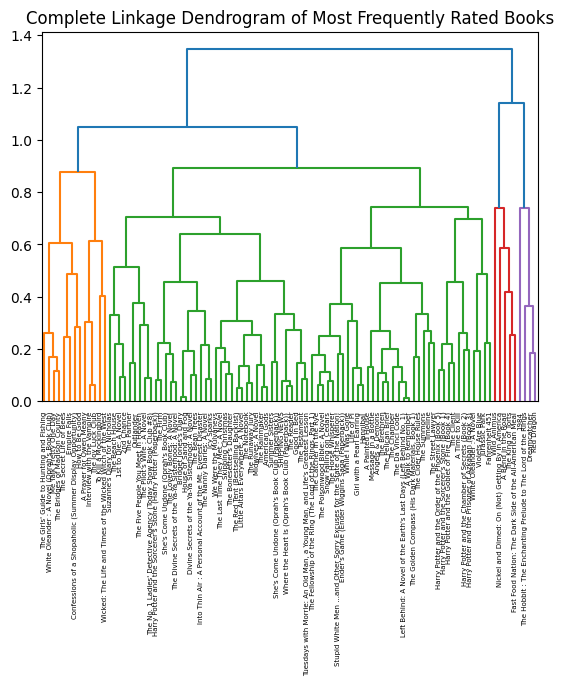

In [374]:
dist_matrix = pd.DataFrame(squareform(pdist(lil_title_vec))).astype(int)

def find_dist(row1, row2):
    row1 = lil_title_vec.iloc[row1]
    row2 = lil_title_vec.iloc[row2]

    x = (row1[genres[0]] - row2[genres[0]]) ** 2
    y = (row1[genres[1]] - row2[genres[1]]) ** 2
    z = (row1[genres[2]] - row2[genres[2]]) ** 2
    distance = (x + z + y) ** 0.5
    return distance

size = 98
for i in range(size):
    for ii in range(size):
        dist_matrix.iat[i, ii] = find_dist(i, ii)

#'''
dist_matrix

D = pdist(dist_matrix)
hc = linkage(dist_matrix, 'complete')
dendrogram(hc, labels=lil_title_vec.index)
plt.title('Complete Linkage Dendrogram of Most Frequently Rated Books')
plt.show()

C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\2640075103.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hc = linkage(dist_matrix, 'ward')


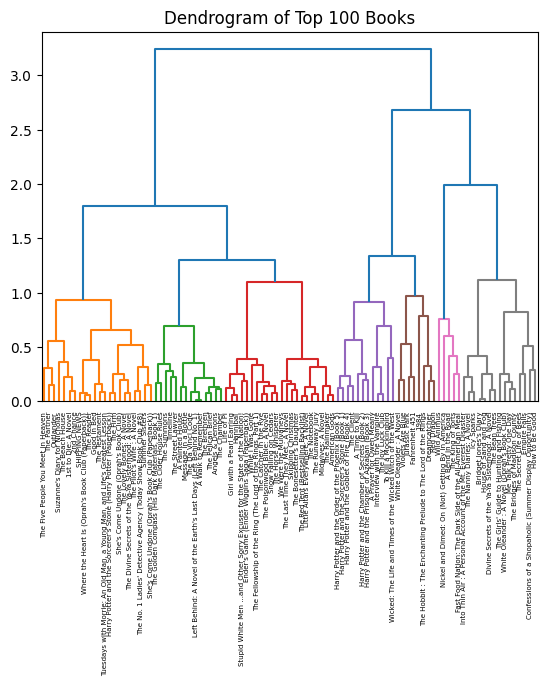

In [375]:
D = pdist(dist_matrix)
hc = linkage(dist_matrix, 'ward')
dendrogram(hc, labels=lil_title_vec.index, color_threshold=1.2)
plt.title("Dendrogram of Top 100 Books")
plt.show()

C:\Users\andyd\AppData\Local\Temp\ipykernel_21440\4273943378.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hc = linkage(dist_matrix, 'ward')


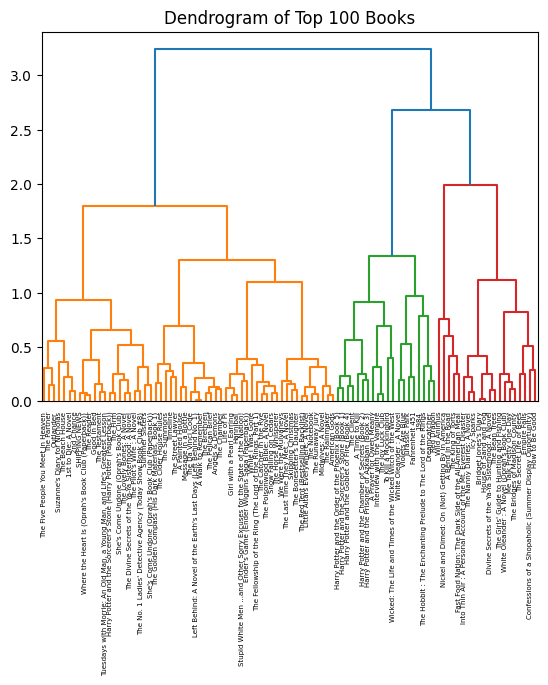

In [376]:
D = pdist(dist_matrix)
hc = linkage(dist_matrix, 'ward')
dendrogram(hc, labels=lil_title_vec.index, color_threshold=2)
plt.title("Dendrogram of Top 100 Books")
plt.show()